In [15]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

# General imports
import numpy as np
import re

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

In [3]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=complex)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix

In [4]:
def convert_qiskit_pauli_string(s):
    # Find all characters followed by a number in brackets
    matches = re.findall(r'([A-Za-z])\((\d+)\)', s)

    # Sort the matches based on the order number (second element in tuple)
    sorted_matches = sorted(matches, key=lambda x: int(x[1]))

    # Join the characters in the sorted order
    return ''.join([char for char, _ in sorted_matches])

In [5]:
# Example usage for a 4x4 matrix
cut_off = 4
q = create_matrix(cut_off, 'q')
p = create_matrix(cut_off, 'p')
H = np.matmul(q,q) + np.matmul(p,p) - 0.5

pauli_decomposed = qml.pauli_decompose(H)
coeffs = pauli_decomposed.coeffs

paulis = []

for x in pauli_decomposed.terms()[1]:
    paulis.append(convert_qiskit_pauli_string(str(x)))


In [23]:
hamiltonian = SparsePauliOp(paulis, coeffs=coeffs)
#hamiltonian = SparsePauliOp.from_list([('III',2), ('IIZ',0.5), ('IZI', -1), ('ZZI',-0.5)])
ansatz = EfficientSU2(hamiltonian.num_qubits)
#ansatz = TwoLocal(hamiltonian.num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [18]:
hamiltonian_isa

SparsePauliOp(['II', 'IX', 'XI', 'XX', 'ZI', 'ZZ'],
              coeffs=[ 2.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -1. +0.j, -1. +0.j])

In [19]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [20]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [21]:
x0

array([1.45462561, 1.64904057, 3.54397127, 5.31402577, 0.54761355,
       4.51080601, 2.52700516, 3.84249044, 5.62305034, 2.59606325,
       3.07419017, 2.58750091, 3.89687245, 1.01233121, 5.47316758,
       2.77857661])

In [22]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000
    #estimator.options.optimization_level = 1

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
    )

Iters. done: 1 [Current cost: 2.1872]
Iters. done: 2 [Current cost: 2.3364]
Iters. done: 3 [Current cost: 2.3174]
Iters. done: 4 [Current cost: 2.5695999999999994]
Iters. done: 5 [Current cost: 2.1041999999999996]
Iters. done: 6 [Current cost: 2.8876]
Iters. done: 7 [Current cost: 2.275]
Iters. done: 8 [Current cost: 2.9052000000000002]
Iters. done: 9 [Current cost: 1.9472000000000003]
Iters. done: 10 [Current cost: 2.2272]
Iters. done: 11 [Current cost: 2.1106]
Iters. done: 12 [Current cost: 2.8126]
Iters. done: 13 [Current cost: 1.5942]
Iters. done: 14 [Current cost: 2.3811999999999998]
Iters. done: 15 [Current cost: 1.6422000000000003]
Iters. done: 16 [Current cost: 1.9697999999999998]
Iters. done: 17 [Current cost: 1.655]
Iters. done: 18 [Current cost: 2.3869999999999996]
Iters. done: 19 [Current cost: 1.8234000000000001]
Iters. done: 20 [Current cost: 1.7075999999999998]
Iters. done: 21 [Current cost: 1.319]
Iters. done: 22 [Current cost: 1.1406000000000003]
Iters. done: 23 [Curre

In [12]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.10542894571054295
       x: [ 8.525e-01  1.312e+00 ...  6.398e-01  5.562e+00]
    nfev: 194
   maxcv: 0.0

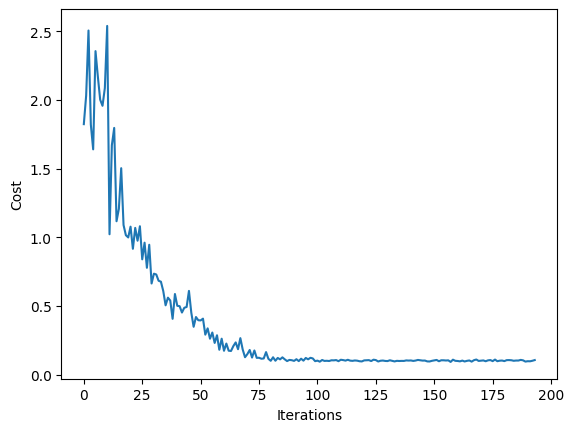

In [13]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()